# Natural Language Generation with LSTM Networks
This notebook implements both a basic RNN and an LSTM network from scratch, along with a creative text generator that produces nature-inspired prose. We'll explore the architecture, mathematics, and implementation of these neural networks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Basic RNN Implementation

The Recurrent Neural Network (RNN) is the foundational architecture for sequence processing. Let's understand its components:

## Core Components:
1. Input Layer: Takes sequence elements one at a time
2. Hidden Layer: Maintains the network's memory state
3. Output Layer: Produces predictions

## Mathematical Formulation:
1. Hidden State Update:

   $$h_t = \tanh(W_{xh}x_t + W_{hh}h_{t-1} + b_h)$$
   
2. Output Computation:
  
   $$y_t = $y_t = \text{softmax}(W_{hy}h_t + b_y)$$

Where:
- $h_t$: Hidden state at time t
- $x_t$: Input at time t
- $W_{xh}$, $W_{hh}$, $W_{hy}$: Weight matrices
- $b_h$, $b_y$: Bias vectors

In [3]:
class RNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        """Initialize RNN with better weight initialization"""
        self.Wxh = np.random.randn(hidden_size, input_size) / np.sqrt(input_size)
        self.Whh = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)
        self.Why = np.random.randn(output_size, hidden_size) / np.sqrt(hidden_size)
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.smooth_loss = -np.log(1.0 / output_size)
        
        self.training_history = {
            'loss': [],
            'accuracy': [],
            'predictions': [],
            'hidden_states': [],
            'confidence': []
        }

    def softmax(self, x):
        """Compute softmax with numerical stability"""
        x = x - np.max(x, axis=0)
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=0)

    def forward(self, inputs, h_prev):
        """Forward pass with stable softmax"""
        self.x_states, self.h_states, self.y_states = {}, {}, {}
        self.h_states[-1] = np.copy(h_prev)
        
        for t in range(len(inputs)):
            self.x_states[t] = inputs[t].reshape(-1, 1)
            
            h_raw = np.dot(self.Wxh, self.x_states[t]) + \
                   np.dot(self.Whh, self.h_states[t-1]) + self.bh
            self.h_states[t] = np.tanh(h_raw)
            
            logits = np.dot(self.Why, self.h_states[t]) + self.by
            self.y_states[t] = self.softmax(logits)
        
        return self.y_states, self.h_states, self.x_states

    def backward(self, targets):
        """Compute gradients with proper scaling"""
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        dh_next = np.zeros((self.hidden_size, 1))
        
        for t in reversed(range(len(targets))):
            dy = np.copy(self.y_states[t])
            dy[targets[t]] -= 1
            
            dWhy += np.dot(dy, self.h_states[t].T)
            dby += dy
            
            dh = np.dot(self.Why.T, dy) + dh_next
            dtanh = (1 - self.h_states[t] ** 2) * dh
            dbh += dtanh
            dWxh += np.dot(dtanh, self.x_states[t].T)
            dWhh += np.dot(dtanh, self.h_states[t-1].T)
            dh_next = np.dot(self.Whh.T, dtanh)
        
        for grad in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(grad, -5, 5, out=grad)
            
        return dWxh, dWhh, dWhy, dbh, dby

    def train_step(self, inputs, targets, h_prev):
        """Perform one training step with proper probability handling"""
        outputs, hidden_states, _ = self.forward(inputs, h_prev)
        
        total_loss = 0.0
        predictions = []
        confidences = []
        hidden_activations = []
        
        for t in range(len(targets)):
            prob = outputs[t][targets[t]]
            total_loss += -np.log(np.maximum(prob, 1e-10))
            
            pred = np.argmax(outputs[t])
            conf = float(np.max(outputs[t]))  
            
            predictions.append(pred)
            confidences.append(conf)
            hidden_activations.append(float(np.mean(np.abs(hidden_states[t]))))
        
        self.smooth_loss = 0.999 * self.smooth_loss + 0.001 * float(total_loss)
        accuracy = np.mean([p == t for p, t in zip(predictions, targets)])
        
        self.training_history['loss'].append(self.smooth_loss)
        self.training_history['accuracy'].append(accuracy)
        self.training_history['predictions'].append(predictions)
        self.training_history['confidence'].append(np.mean(confidences))
        self.training_history['hidden_states'].append(np.mean(hidden_activations))
        
        gradients = self.backward(targets)
        self.update_parameters(*gradients)
        
        return self.smooth_loss, hidden_states[len(inputs)-1]

    def update_parameters(self, dWxh, dWhh, dWhy, dbh, dby):
        """Update parameters with adaptive step sizes"""
        for param, dparam in [
            (self.Wxh, dWxh), 
            (self.Whh, dWhh),
            (self.Why, dWhy),
            (self.bh, dbh),
            (self.by, dby)
        ]:
            step = self.learning_rate * dparam
            param -= step

    def plot_training_progress(self):
        """Plot training metrics with improved visualization"""
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        plt.plot(self.training_history['loss'], 'b-', label='Loss', linewidth=2)
        plt.title('Training Loss', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.plot(self.training_history['accuracy'], 'g-', label='Accuracy', linewidth=2)
        plt.title('Model Accuracy', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.legend()
        
        plt.subplot(2, 2, 3)
        plt.plot(self.training_history['confidence'], color='orange', label='Confidence', linewidth=2)
        plt.title('Prediction Confidence', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Confidence')
        plt.grid(True)
        plt.legend()
        
        plt.subplot(2, 2, 4)
        plt.plot(self.training_history['hidden_states'], color='purple', label='Activity', linewidth=2)
        plt.title('Hidden State Activity', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Activation')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def predict(self, x, h):
        """Make a single prediction"""
        outputs, new_h, _ = self.forward([x], h)
        prediction = np.argmax(outputs[0])
        confidence = float(np.max(outputs[0]))
        return prediction, confidence, new_h[0]

    def print_prediction_analysis(self, inputs, targets, epoch):
        """Print detailed analysis"""
        h = np.zeros((self.hidden_size, 1))
        outputs, _, _ = self.forward(inputs, h)
        
        predictions = []
        confidences = []
        for t in range(len(targets)):
            pred = np.argmax(outputs[t])
            conf = float(np.max(outputs[t]))
            predictions.append(pred)
            confidences.append(conf)
        
        print(f"\nEpoch {epoch} Analysis:")
        print("-" * 50)
        print("Sample Predictions (First 10 sequences):")
        print(f"{'Index':^6} {'Target':^8} {'Predicted':^10} {'Correct':^8} {'Confidence':^12}")
        print("-" * 50)
        
        for i in range(min(10, len(targets))):
            correct = "✓" if predictions[i] == targets[i] else "✗"
            print(f"{i:^6d} {targets[i]:^8d} {predictions[i]:^10d} {correct:^8} {confidences[i]:^12.4f}")
        
        class_counts = np.bincount(predictions, minlength=self.output_size)
        total_preds = len(predictions)
        
        print("\nClass Distribution:")
        for i in range(self.output_size):
            percentage = (class_counts[i] / total_preds) * 100
            print(f"Class {i}: {percentage:.1f}% ({class_counts[i]} predictions)")
        
        accuracy = np.mean([p == t for p, t in zip(predictions, targets)])
        mean_confidence = np.mean(confidences)
        
        print("\nSummary Statistics:")
        print(f"Overall Accuracy: {accuracy:.2%}")
        print(f"Mean Confidence: {mean_confidence:.4f}")
        print(f"Current Loss: {self.smooth_loss:.2f}")

## Sample Data Generation
The `create_toy_data` function generates sequential patterns for testing the RNN:
- Creates cyclic patterns
- Uses one-hot encoding for inputs
- Generates corresponding target labels

In [5]:
def create_toy_data(sequence_length=25, input_size=5):
    """Create sequential pattern data"""
    inputs = []
    targets = []
    
    for i in range(sequence_length):
        current_class = i % input_size
        next_class = (current_class + 1) % input_size
        
        input_vec = np.zeros(input_size)
        input_vec[current_class] = 1
        inputs.append(input_vec)
        targets.append(next_class)
    
    return inputs, targets

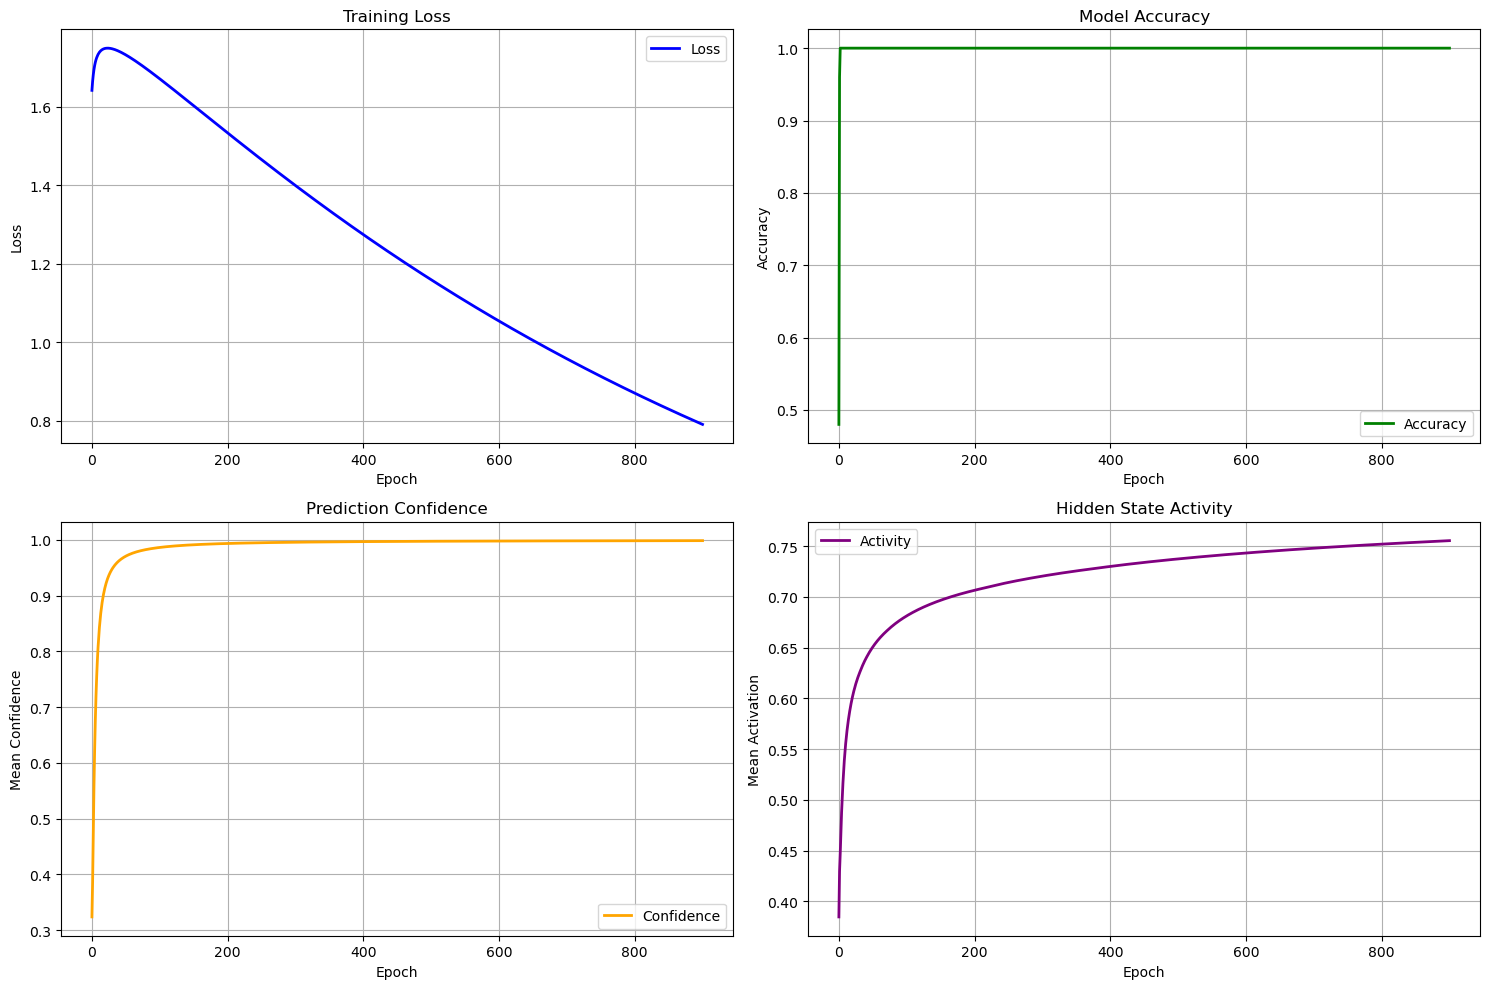


Epoch 900 Analysis:
--------------------------------------------------
Sample Predictions (First 10 sequences):
Index   Target  Predicted  Correct   Confidence 
--------------------------------------------------
  0       1         0         ✗        0.3420   
  1       2         2         ✓        0.8779   
  2       3         3         ✓        0.9831   
  3       4         4         ✓        0.9946   
  4       0         0         ✓        0.9951   
  5       1         1         ✓        0.9981   
  6       2         2         ✓        0.9985   
  7       3         3         ✓        0.9986   
  8       4         4         ✓        0.9986   
  9       0         0         ✓        0.9986   

Class Distribution:
Class 0: 24.0% (6 predictions)
Class 1: 16.0% (4 predictions)
Class 2: 20.0% (5 predictions)
Class 3: 20.0% (5 predictions)
Class 4: 20.0% (5 predictions)

Summary Statistics:
Overall Accuracy: 96.00%
Mean Confidence: 0.9666
Current Loss: 0.79


In [7]:
if __name__ == "__main__":
    input_size = 5
    hidden_size = 32
    output_size = 5
    learning_rate = 0.005
    
    rnn = RNN(input_size, hidden_size, output_size, learning_rate)
    
    inputs, targets = create_toy_data()
    
    print("Training Pattern (first 5 samples):")
    for i in range(5):
        input_class = np.argmax(inputs[i])
        print(f"Input {input_class} -> Target {targets[i]}")
    
    n_epochs = 1000
    h_prev = np.zeros((hidden_size, 1))
    
    for epoch in range(n_epochs):
        loss, h_prev = rnn.train_step(inputs, targets, h_prev)
        
        if epoch % 100 == 0:
            clear_output(wait=True)
            rnn.plot_training_progress()
            rnn.print_prediction_analysis(inputs, targets, epoch)
            plt.close()

# LSTM Implementation

## LSTM Architecture
Long Short-Term Memory (LSTM) networks extend the basic RNN with specialized gates:

### Gates:
1. Input Gate (i): Controls new information flow
2. Forget Gate (f): Manages memory retention
3. Cell Gate (g): Creates potential memory content
4. Output Gate (o): Controls information output

### State Components:
1. Cell State (c): Long-term memory
2. Hidden State (h): Working memory

## Mathematical Formulation:

$$i_t = \sigma(W_{ii} \cdot x_t + W_{hi} \cdot h_{t-1} + b_i)$$
$$f_t = \sigma(W_{if} \cdot x_t + W_{hf} \cdot h_{t-1} + b_f)$$
$$g_t = \tanh(W_{ig} \cdot x_t + W_{hg} \cdot h_{t-1} + b_g)$$
$$o_t = \sigma(W_{io} \cdot x_t + W_{ho} \cdot h_{t-1} + b_o)$$
$$c_t = f_t \odot c_{t-1} + i_t \odot g_t$$
$$h_t = o_t \odot \tanh(c_t)$$

In [9]:
class LSTM:
    def __init__(self, input_size, hidden_size):
        """
        Initialize LSTM cell parameters
        
        Args:
            input_size: Size of input features
            hidden_size: Size of hidden state and cell state
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.Wii = np.random.randn(hidden_size, input_size) / np.sqrt(input_size)
        self.Whi = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)
        self.bi = np.zeros((hidden_size, 1))
        
        self.Wif = np.random.randn(hidden_size, input_size) / np.sqrt(input_size)
        self.Whf = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)
        self.bf = np.zeros((hidden_size, 1))
        
        self.Wig = np.random.randn(hidden_size, input_size) / np.sqrt(input_size)
        self.Whg = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)
        self.bg = np.zeros((hidden_size, 1))
        
        self.Wio = np.random.randn(hidden_size, input_size) / np.sqrt(input_size)
        self.Who = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)
        self.bo = np.zeros((hidden_size, 1))
        
        self.dWii = np.zeros_like(self.Wii)
        self.dWhi = np.zeros_like(self.Whi)
        self.dbi = np.zeros_like(self.bi)
        
        self.dWif = np.zeros_like(self.Wif)
        self.dWhf = np.zeros_like(self.Whf)
        self.dbf = np.zeros_like(self.bf)
        
        self.dWig = np.zeros_like(self.Wig)
        self.dWhg = np.zeros_like(self.Whg)
        self.dbg = np.zeros_like(self.bg)
        
        self.dWio = np.zeros_like(self.Wio)
        self.dWho = np.zeros_like(self.Who)
        self.dbo = np.zeros_like(self.bo)

    def sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        """Derivative of sigmoid function"""
        return x * (1 - x)
    
    def tanh_derivative(self, x):
        """Derivative of tanh function"""
        return 1 - x * x

    def forward(self, x, h_prev, c_prev):
        """
        Forward pass of LSTM
        
        Args:
            x: Input at current timestep (input_size, batch_size)
            h_prev: Previous hidden state (hidden_size, batch_size)
            c_prev: Previous cell state (hidden_size, batch_size)
            
        Returns:
            h: Current hidden state
            c: Current cell state
            cache: Cache for backward pass
        """
        assert x.shape[0] == self.input_size
        assert h_prev.shape[0] == self.hidden_size
        assert c_prev.shape[0] == self.hidden_size
        
        i = self.sigmoid(np.dot(self.Wii, x) + np.dot(self.Whi, h_prev) + self.bi)
        
        f = self.sigmoid(np.dot(self.Wif, x) + np.dot(self.Whf, h_prev) + self.bf)
        
        g = np.tanh(np.dot(self.Wig, x) + np.dot(self.Whg, h_prev) + self.bg)
        
        o = self.sigmoid(np.dot(self.Wio, x) + np.dot(self.Who, h_prev) + self.bo)
        
        c = f * c_prev + i * g
        
        h = o * np.tanh(c)
        
        cache = (x, h_prev, c_prev, i, f, g, o, c)
        
        return h, c, cache

    def backward(self, dh, dc, cache):
        """
        Backward pass of LSTM
        
        Args:
            dh: Gradient of loss with respect to hidden state (hidden_size, batch_size)
            dc: Gradient of loss with respect to cell state (hidden_size, batch_size)
            cache: Cache from forward pass
            
        Returns:
            dx: Gradient with respect to input x
            dh_prev: Gradient with respect to previous hidden state
            dc_prev: Gradient with respect to previous cell state
        """
        x, h_prev, c_prev, i, f, g, o, c = cache
        batch_size = x.shape[1]
        
        do = dh * np.tanh(c)
        dc = dc + dh * o * (1 - np.tanh(c) ** 2)
        
        di = dc * g
        df = dc * c_prev
        dg = dc * i
        
        di = di * self.sigmoid_derivative(i)
        df = df * self.sigmoid_derivative(f)
        dg = dg * (1 - g ** 2)  
        do = do * self.sigmoid_derivative(o)
        
        self.dWii += np.dot(di, x.T)
        self.dWhi += np.dot(di, h_prev.T)
        self.dbi += np.sum(di, axis=1, keepdims=True)
        
        self.dWif += np.dot(df, x.T)
        self.dWhf += np.dot(df, h_prev.T)
        self.dbf += np.sum(df, axis=1, keepdims=True)
        
        self.dWig += np.dot(dg, x.T)
        self.dWhg += np.dot(dg, h_prev.T)
        self.dbg += np.sum(dg, axis=1, keepdims=True)
        
        self.dWio += np.dot(do, x.T)
        self.dWho += np.dot(do, h_prev.T)
        self.dbo += np.sum(do, axis=1, keepdims=True)
        
        dx = (np.dot(self.Wii.T, di) + np.dot(self.Wif.T, df) + 
              np.dot(self.Wig.T, dg) + np.dot(self.Wio.T, do))
        
        dh_prev = (np.dot(self.Whi.T, di) + np.dot(self.Whf.T, df) +
                  np.dot(self.Whg.T, dg) + np.dot(self.Who.T, do))
        
        dc_prev = dc * f
        
        return dx, dh_prev, dc_prev

    def update_params(self, learning_rate):
        """Update parameters using gradients and learning rate"""
        self.Wii -= learning_rate * self.dWii
        self.Whi -= learning_rate * self.dWhi
        self.bi -= learning_rate * self.dbi
        
        self.Wif -= learning_rate * self.dWif
        self.Whf -= learning_rate * self.dWhf
        self.bf -= learning_rate * self.dbf
        
        self.Wig -= learning_rate * self.dWig
        self.Whg -= learning_rate * self.dWhg
        self.bg -= learning_rate * self.dbg
        
        self.Wio -= learning_rate * self.dWio
        self.Who -= learning_rate * self.dWho
        self.bo -= learning_rate * self.dbo
        
        self.dWii = np.zeros_like(self.Wii)
        self.dWhi = np.zeros_like(self.Whi)
        self.dbi = np.zeros_like(self.bi)
        
        self.dWif = np.zeros_like(self.Wif)
        self.dWhf = np.zeros_like(self.Whf)
        self.dbf = np.zeros_like(self.bf)
        
        self.dWig = np.zeros_like(self.Wig)
        self.dWhg = np.zeros_like(self.Whg)
        self.dbg = np.zeros_like(self.bg)
        
        self.dWio = np.zeros_like(self.Wio)
        self.dWho = np.zeros_like(self.Who)
        self.dbo = np.zeros_like(self.bo)

In [11]:
def example():
    input_size = 10
    hidden_size = 20
    lstm = LSTM(input_size, hidden_size)
    
    batch_size = 1
    x = np.random.randn(input_size, batch_size)
    h_prev = np.zeros((hidden_size, batch_size))
    c_prev = np.zeros((hidden_size, batch_size))
    
    h, c, cache = lstm.forward(x, h_prev, c_prev)
    
    dh = np.random.randn(hidden_size, batch_size)
    dc = np.random.randn(hidden_size, batch_size)
    
    dx, dh_prev, dc_prev = lstm.backward(dh, dc, cache)
    
    learning_rate = 0.01
    lstm.update_params(learning_rate)
    
    return h, c, dx, dh_prev, dc_prev

if __name__ == "__main__":
    h, c, dx, dh_prev, dc_prev = example()
    print("Hidden state shape:", h.shape)
    print("Cell state shape:", c.shape)
    print("Input gradient shape:", dx.shape)
    print("Hidden state gradient shape:", dh_prev.shape)
    print("Cell state gradient shape:", dc_prev.shape)

Hidden state shape: (20, 1)
Cell state shape: (20, 1)
Input gradient shape: (10, 1)
Hidden state gradient shape: (20, 1)
Cell state gradient shape: (20, 1)


# Creative Text Generator

## Overview
The `CreativeTextGenerator` class combines LSTM capabilities with structured text generation:

### Key Features:
1. Pattern-based training data
2. Character-level text generation
3. Temperature-controlled sampling
4. Dynamic training process

## Training Data Structure:
1. Basic Patterns: Simple sentences
2. Nature Scenes: Environmental descriptions
3. Transitions: Temporal bridges
4. Compound Patterns: Complex narratives

## Vocabulary Categories:
- Animals: Living creatures
- Actions: Movement and behaviors
- Places: Natural locations
- Weather: Environmental conditions
- Times: Temporal markers
- Manner: Description modifiers

In [13]:
class CreativeLSTM:
    def __init__(self, input_size, hidden_size, learning_rate=0.01):
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
        scale = 0.08
        
        self.Wih = np.random.randn(hidden_size, input_size) * scale
        self.Whh = np.random.randn(hidden_size, hidden_size) * scale
        
        self.Wfh = np.random.randn(hidden_size, hidden_size) * scale
        self.Wfx = np.random.randn(hidden_size, input_size) * scale
        
        self.Why = np.random.randn(input_size, hidden_size) * scale * 0.5
        
        self.bh = np.zeros((hidden_size, 1))
        self.bf = np.ones((hidden_size, 1))  
        self.by = np.zeros((input_size, 1))
        
        self.noise_scale = 0.01

    def forward(self, x, h_prev, c_prev):
        """Forward pass with exploration noise"""
        if self.training:
            h_prev = h_prev + np.random.randn(*h_prev.shape) * self.noise_scale
        
        i = self.sigmoid(np.dot(self.Wih, x) + np.dot(self.Whh, h_prev) + self.bh)
        
        f = self.sigmoid(np.dot(self.Wfh, h_prev) + np.dot(self.Wfx, x) + self.bf)
        
        c_tilde = np.tanh(np.dot(self.Wih, x) + np.dot(self.Whh, h_prev))
        c = f * c_prev + i * c_tilde
        
        h = np.tanh(c)
        y = np.dot(self.Why, h) + self.by
        
        self.cache = (x, h_prev, c_prev, i, f, c_tilde, c, h)
        return h, c, y

    def backward(self, dy, dh_next, dc_next):
        """Backward pass with gradient clipping"""
        x, h_prev, c_prev, i, f, c_tilde, c, h = self.cache
        
        dWhy = np.dot(dy, h.T)
        dby = dy
        dh = np.dot(self.Why.T, dy) + dh_next
        
        dc = dh * (1 - np.tanh(c)**2) + dc_next
        
        di = dc * c_tilde * i * (1 - i)
        df = dc * c_prev * f * (1 - f)
        dc_tilde = dc * i * (1 - c_tilde**2)
        
        dWih = np.dot(di, x.T) + np.dot(dc_tilde, x.T)
        dWhh = np.dot(di, h_prev.T) + np.dot(dc_tilde, h_prev.T)
        dWfh = np.dot(df, h_prev.T)
        dWfx = np.dot(df, x.T)
        
        dbh = np.sum(di + dc_tilde, axis=1, keepdims=True)
        dbf = np.sum(df, axis=1, keepdims=True)
        
        clip = lambda x: np.clip(x, -5, 5)
        
        self.Wih -= self.learning_rate * clip(dWih)
        self.Whh -= self.learning_rate * clip(dWhh)
        self.Wfh -= self.learning_rate * clip(dWfh)
        self.Wfx -= self.learning_rate * clip(dWfx)
        self.Why -= self.learning_rate * clip(dWhy)
        self.bh -= self.learning_rate * clip(dbh)
        self.bf -= self.learning_rate * clip(dbf)
        self.by -= self.learning_rate * clip(dby)
        
        dx = np.dot(self.Wih.T, di) + np.dot(self.Wfx.T, df)
        dh_prev = (np.dot(self.Whh.T, di) + np.dot(self.Wfh.T, df))
        dc_prev = f * dc
        
        return dx, dh_prev, dc_prev

    def sigmoid(self, x):
        """Numerically stable sigmoid"""
        x = np.clip(x, -15, 15)
        return 1 / (1 + np.exp(-x))

## Pattern Generation System
The text generator uses structured patterns to create coherent narratives:

### Pattern Types:
1. Basic: "the {animal} {action}"
2. Location: "in the {place}"
3. Action: "the {animal} {verb} {manner}"
4. Compound: Combined patterns for complex sentences

### Text Generation Process:
1. Pattern selection
2. Vocabulary sampling
3. Pattern filling
4. Sentence combination

In [15]:
class CreativeTextGenerator:
    def __init__(self, hidden_size=64):
        self.hidden_size = hidden_size
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.model = None

    def create_training_data(self):
        """Create training data with clearer word boundaries and structured patterns"""
    
        core_patterns = {
            'basic': [
                ("the {} . ", ['animals']),
                ("a {} . ", ['animals']),
                ("it is {} . ", ['weather']),
                ("the day is {} . ", ['weather'])
            ],
            'location': [
                ("in the {} . ", ['places']),
                ("by the {} . ", ['places']),
                ("near the {} . ", ['places']),
                ("under the {} . ", ['places'])
            ],
            'action': [
                ("the {} {} . ", ['animals', 'verbs']),
                ("a {} {} . ", ['animals', 'verbs']),
                ("the {} {} quietly . ", ['animals', 'verbs']),
                ("a {} {} softly . ", ['animals', 'verbs'])
            ],
            'compound': [
                ("the {} {} and the {} {} . ", ['animals', 'verbs', 'animals', 'verbs']),
                ("while the {} {} , the {} {} . ", ['animals', 'verbs', 'animals', 'verbs'])
            ]
        }
        
        vocabulary = {
        'animals': ["cat", "dog", "bird", "fox", "owl", "deer", "wolf", "bear", "rabbit", "squirrel",
                   "mouse", "hawk", "duck", "fawn", "hare"],
        'actions': ["walks", "runs", "sits", "rests", "sleeps", "hunts", "watches", "moves", "leaps", "plays",
                   "prowls", "dashes", "glides", "roams", "wanders"],
        'places': ["forest", "river", "lake", "cave", "field", "hill", "stream", "meadow", "garden", "path",
                  "valley", "grove", "marsh", "glade", "hollow"],
        'weather': ["sunny", "cloudy", "rainy", "clear", "warm", "cool", "misty", "bright", "mild", "fresh",
                   "breezy", "crisp", "gentle", "peaceful", "quiet"],
        'times': ["morning", "evening", "dusk", "dawn", "night", "sunset", "twilight", "noon", "daybreak", "nightfall",
                 "sunrise", "midnight", "afternoon", "daylight", "moonrise"],
        'manner': ["quietly", "softly", "gently", "slowly", "peacefully", "gracefully", "carefully", "steadily", "calmly", "silently",
                  "swiftly", "lightly", "smoothly", "stealthily", "easily"]
        }
    
        patterns = [
            ("the {} {} through the {} . ", ['animals', 'actions', 'places']),
            ("a {} {} {} in the {} . ", ['animals', 'actions', 'manner', 'places']),
            
            ("at {} the {} {} {} . ", ['times', 'animals', 'actions', 'manner']),
            ("as {} approaches, a {} {} {} . ", ['times', 'animals', 'actions', 'manner']),
            ("in the {} light, the {} {} . ", ['times', 'animals', 'actions']),
            
            ("beneath the {} sky, a {} {} . ", ['weather', 'animals', 'actions']),
            ("in the {} air, the {} {} {} . ", ['weather', 'animals', 'actions', 'manner']),
            ("through the {} mist, a {} {} . ", ['weather', 'animals', 'actions']),
            
            ("deep in the {}, a {} {} {} . ", ['places', 'animals', 'actions', 'manner']),
            ("by the {} waters, the {} {} . ", ['weather', 'animals', 'actions']),
            ("across the {} {}, a {} {} . ", ['weather', 'places', 'animals', 'actions']),
            
            ("the {} {} while the {} {} in the {} . ", ['animals', 'actions', 'animals', 'actions', 'places']),
            ("as the {} {}, a {} {} {} . ", ['animals', 'actions', 'animals', 'actions', 'manner']),
            ("near the {}, the {} {} as a {} {} . ", ['places', 'animals', 'actions', 'animals', 'actions'])
        ]
    
        def generate_pattern(pattern, categories):
            """Generate text with constraints to prevent repetition"""
            max_attempts = 10
            for _ in range(max_attempts):
                words = []
                used_words = set()  
                valid = True
                
                for cat in categories:
                    available_words = [w for w in vocabulary[cat] if w not in used_words]
                    if not available_words:  
                        valid = False
                        break
                        
                    word = np.random.choice(available_words)
                    words.append(word)
                    used_words.add(word)  
                    
                    if cat in ['actions', 'animals']:
                        used_words.update(word)    
                
                if valid:
                    return pattern.format(*words)
            
            return "the wind whispers softly . "
    
        sentences = []
        
        for pattern, categories in patterns:
            for _ in range(8):    
                sentences.append(generate_pattern(pattern, categories))
        
        nature_scenes = [
            "sunlight dances through leaves . ",
            "shadows stretch across earth . ",
            "water flows endlessly onward . ",
            "stars glitter in darkness . ",
            "clouds drift in silence . ",
            "moonlight bathes the land . ",
            "branches sway in wind . ",
            "mist rises from earth . ",
            "flowers turn to light . ",
            "rain falls like music . ",
            "thunder echoes distant . ",
            "frost sparkles brightly . ",
            "waves lap at shore . ",
            "grass bends in breeze . ",
            "leaves whisper secrets . "
        ]
        sentences.extend(nature_scenes)
        
        transitions = [
            "nature awakens slowly . ",
            "time flows like water . ",
            "silence spreads gently . ",
            "life pulses onward . ",
            "darkness deepens slowly . ",
            "light changes softly . ",
            "wind carries stories . ",
            "seasons turn slowly . ",
            "peace settles deeply . ",
            "morning light grows . ",
            "evening shadows stretch . ",
            "night draws closer . ",
            "dawn approaches quiet . ",
            "dusk falls gently . ",
            "day fades to night . "
        ]
        sentences.extend(transitions)
        
        complete_text = []
        for _ in range(3):  
            np.random.shuffle(sentences)
            text_section = "".join(sentences)
            complete_text.append(text_section)
        
        return "".join(complete_text)

    def prepare_data(self, text):
        """Prepare text with minimal preprocessing"""
        text = text.lower()
        
        chars = sorted(list(set(text)))
        self.char_to_idx = {char: idx for idx, char in enumerate(chars)}
        self.idx_to_char = {idx: char for idx, char in enumerate(chars)}
        self.model = CreativeLSTM(len(chars), self.hidden_size)
        self.model.training = True
        
        return text

    def train(self, text=None, num_epochs=50):
        """Train with dynamic text generation"""
        if text is None:
            text = self.create_training_data()
        
        text = self.prepare_data(text)
        sequence_length = 25
        
        print("Training text sample:", text[:200])  
        
        for epoch in range(num_epochs):
            total_loss = 0
            h = np.zeros((self.hidden_size, 1))
            c = np.zeros((self.hidden_size, 1))
            
            positions = range(0, len(text) - sequence_length - 1, 3)
            for pos in positions:
                sequence = text[pos:pos + sequence_length]
                target = text[pos + 1:pos + sequence_length + 1]
                
                loss = 0
                for t in range(sequence_length):
                    x = np.zeros((len(self.char_to_idx), 1))
                    x[self.char_to_idx[sequence[t]]] = 1
                    
                    h, c, y = self.model.forward(x, h, c)
                    
                    target_idx = self.char_to_idx[target[t]]
                    probs = self.softmax(y)
                    loss -= np.log(probs[target_idx] + 1e-10)
                    
                    dy = probs.copy()
                    dy[target_idx] -= 1
                    self.model.backward(dy, np.zeros_like(h), np.zeros_like(c))
                
                total_loss += float(loss)
                
                if pos % 100 == 0:
                    avg_loss = float(loss) / sequence_length
                    print(f"\nEpoch {epoch+1}, Position {pos}, Loss: {avg_loss:.4f}")
                    print("Sample:", self.generate_text("the ", 50))
            
            avg_epoch_loss = total_loss / len(positions)
            print(f"\nEpoch {epoch+1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}")
    
    def generate_text(self, seed_text, length=100, temperature=0.7):
        """Generate text with improved sampling"""
        self.model.training = False
        h = np.zeros((self.hidden_size, 1))
        c = np.zeros((self.hidden_size, 1))
        text = seed_text.lower()
        
        for char in text:
            x = np.zeros((len(self.char_to_idx), 1))
            if char in self.char_to_idx:
                x[self.char_to_idx[char]] = 1
                h, c, _ = self.model.forward(x, h, c)
        
        for i in range(length):
            x = np.zeros((len(self.char_to_idx), 1))
            if text[-1] in self.char_to_idx:
                x[self.char_to_idx[text[-1]]] = 1
                
                h, c, y = self.model.forward(x, h, c)
                
                local_temp = temperature * (1 + 0.1 * np.sin(i * np.pi / 10))
                y = y / local_temp
                
                probs = self.softmax(y)
                idx = np.random.choice(len(self.char_to_idx), p=probs.ravel())
                
                next_char = self.idx_to_char[idx]
                text += next_char
                
                if next_char in '.!?' and i < length - 1:
                    text += ' '
            
        return text
    
    def softmax(self, x):
        """Compute softmax with improved numerical stability"""
        x = x - np.max(x)
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x)

## LSTM Training Process

### Forward Pass:
1. Character encoding
2. State propagation
3. Output generation

### Backward Pass:
1. Error computation
2. Gradient calculation
3. Parameter updates

### Hyperparameters:
- sequence_length = 25
- hidden_size = 256
- learning_rate = 0.01
- temperature range: 0.5 - 1.0

## Text Generation Parameters

### Temperature Control:
- Low (0.5): More focused, deterministic output
- Medium (0.7): Balanced creativity
- High (1.0): More random, creative output

### Generation Process:
1. Seed text initialization
2. Character-by-character generation
3. Dynamic temperature adjustment
4. Punctuation and spacing handling

In [17]:
def main():
    np.random.seed(42)
    
    print("Training model...")
    model = CreativeTextGenerator(hidden_size=256)
    model.train(num_epochs=150)
    
    print("\nGenerating samples:")
    
    print("\nTemperature 0.5:")
    print(model.generate_text("the ", 100, 0.5))
    
    print("\nTemperature 0.7:")
    print(model.generate_text("the ", 100, 0.7))
    
    print("\nTemperature 1.0:")
    print(model.generate_text("the ", 100, 1.0))


if __name__ == "__main__":
    main()

Training model...
Training text sample: as the bird roams, a squirrel sits calmly . in the midnight light, the hawk glides . darkness deepens slowly . by the bright waters, the hare prowls . by the warm waters, the cat moves . shadows stret

Epoch 1, Position 0, Loss: 3.4031
Sample: the aknikmf vbevmamfyxu. mhlxisv,utcvhbatxk unpxq. zu,tq


/tmp/ipykernel_227526/3797879926.py:197: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total_loss += float(loss)
/tmp/ipykernel_227526/3797879926.py:200: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  avg_loss = float(loss) / sequence_length



Epoch 1, Position 300, Loss: 3.0696
Sample: the damehs. h avha. hr s r  iast csst. rol ti  als stayt.

Epoch 1, Position 600, Loss: 3.1420
Sample: the  waolevr ous. ttnt ,roxh unhrgmvtteatetttt thnntiut

Epoch 1, Position 900, Loss: 3.0467
Sample: the ttbylal. teu e. rs al aternr  er s  sasd rxo oywia s

Epoch 1, Position 1200, Loss: 3.0326
Sample: the thgaaltahsa alwaat haprt s a aaa gde s dkg p g. hdl

Epoch 1, Position 1500, Loss: 2.2405
Sample: the soas in taan th ei asn ry i hhe tit uyearl asn nnr

Epoch 1, Position 1800, Loss: 2.2969
Sample: the areed lane . the t oaes . . . ahee s te the ts mefr hr

Epoch 1, Position 2100, Loss: 2.5027
Sample: the bees . heee s oa sa the w dools se . oasop deg lis a

Epoch 1, Position 2400, Loss: 2.2140
Sample: the ailethesuryt the cao riluy biwbbb . he ihs thers wa

Epoch 1, Position 2700, Loss: 1.4394
Sample: the ilnrathe auelth raln the roliwthe aonl . anil rrr m

Epoch 1, Position 3000, Loss: 1.6985
Sample: the walee dit the . heeue de the 